In [6]:
dir = "/home/user/georgy/Results/starcoder/Starcoder1024Tokens32LoraRankSummaries/"
test_filename = "starcoder_summaries_test.jsonl"
preds_filename = "StarcoderWithSummaries.csv"
prev_preds_filename = "Starcoder1024Tokens32LoraForSummariesComparison.csv"

In [7]:
import pandas as pd
import json
import numpy as np

In [8]:
preds_df = pd.read_csv(dir + preds_filename, sep='\t', index_col=0, header=None)
preds_df

,1
0,
0,due to a crash
1,It is a variable that counts the number of tim...
2,the match strength between two strings
3,the linear conformance factor of f
4,that the builtin registry matches the remote r...
...,...
8223,the name of the encoding
8224,a simple traceback
8225,with a seeded random loader


In [4]:
from datasets import load_dataset

dataset = load_dataset(
    "datapaf/UltimateQASummaries",
    # data_dir=".",
    split="test",
    token=True,
)

In [15]:
import bert_score

summaries_scores = bert_score.score(
    preds_df.iloc[:, 0].to_list(),
    [ex['answer'] for ex in dataset],
    verbose=True,
    model_type='microsoft/deberta-xlarge-mnli',
    device='cuda:1'
)

calculating scores...
computing bert embedding.


  0%|          | 0/217 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/129 [00:00<?, ?it/s]

done in 27.63 seconds, 297.74 sentences/sec


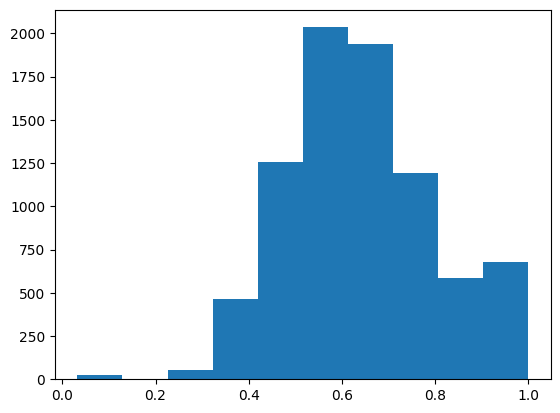

In [18]:
import matplotlib.pyplot as plt

plt.hist(summaries_scores[2])
plt.show()

In [11]:
prev_preds_df = pd.read_csv(prev_preds_filename, sep='\t', index_col=0, header=None)
prev_preds_df = prev_preds_df.fillna("")
prev_preds_df

,1
0,
0,non
1,It is a variable that counts the number of tim...
2,the match strength between two strings
3,the leading coefficient of f
4,that the builtin registry matches the download...
...,...
8223,the name of the encoding
8224,a simple traceback
8225,with a seeded random loader


In [19]:
import bert_score

no_summaries_scores = bert_score.score(
    prev_preds_df.iloc[:, 0].to_list(),
    [ex['answer'] for ex in dataset],
    verbose=True,
    model_type='microsoft/deberta-xlarge-mnli',
    device='cuda:1'
)

calculating scores...
computing bert embedding.


  0%|          | 0/221 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/129 [00:00<?, ?it/s]

done in 28.34 seconds, 290.34 sentences/sec


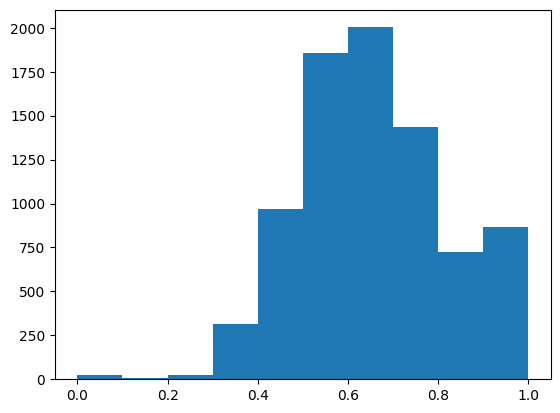

In [20]:
import matplotlib.pyplot as plt

plt.hist(no_summaries_scores[2])
plt.show()

In [46]:
idx_worse = np.where(no_summaries_scores[2] - summaries_scores[2] > 0.001)[0]
len(idx_worse) / len(dataset)

0.388065143412737

In [32]:
idx_worse = np.where(summaries_scores[2] < no_summaries_scores[2])[0]
idx_worse

array([   3,    7,   11, ..., 8223, 8226, 8227])

In [33]:
len(idx_worse) / len(dataset)

0.4630529897909577

In [40]:
analysis_df = pd.DataFrame(dataset[idx_worse])
analysis_df

,question,summary,code,answer
0,What computes in k[x_0 ?,the linear conformance factor lc,def _LC(f):\n\tring = f.ring\n\tk = ring.ngens...,the leading coefficient of a multivariate poly...
1,What does this function do?,delete a customer from stripe,def delete_customer(customer_id):\n\ttry:\n\t\...,"Delete customer from Stripe, cancelling subscr..."
2,What do a unix pipeline process ?,returns a pipeline to upload the data from in ...,"def get_upload_pipeline(in_fd, out_fd, rate_li...",a file for uploading
3,What does this function provide ?,load a source file,"def load_source(name, pathname):\n\tif six.PY2...",the backward compatibility for imp
4,What does the code return ?,get the directory time suffix,def get_dir_time_suffix():\n\tdirfmt = '%4d-%0...,the name of a folder with the now time as suffix
...,...,...,...,...
3805,What have dependencies to_process : set of nod...,initial has dependencies,"def initial_has_dependencies(tree, to_process)...",all nodes that are nt processed up front stll
3806,What do the twisted mainloop configure ?,installs the reactor,def install():\n\treactor = WxReactor()\n\tfro...,to be run inside the wxpython mainloop
3807,"What does "" normalized "" be where ?",returns the normalized name of the encoding,def _norm_encoding(encoding):\n\ttry:\n\t\tret...,what pythons codecs module calls it
3808,What do a github release use ?,release the current version to the repository,@release.command()\ndef ghrelease():\n\tversio...,the github - release command - line tool


In [41]:
analysis_df['prev_pred'] = prev_preds_df.iloc[idx_worse, 0].to_list()
analysis_df['pred'] = preds_df.iloc[idx_worse, 0].to_list()
analysis_df['score_drop'] = no_summaries_scores[2][idx_worse] - summaries_scores[2][idx_worse] 
analysis_df

,question,summary,code,answer,prev_pred,pred,score_drop
0,What computes in k[x_0 ?,the linear conformance factor lc,def _LC(f):\n\tring = f.ring\n\tk = ring.ngens...,the leading coefficient of a multivariate poly...,the leading coefficient of f,the linear conformance factor of f,5.984080e-02
1,What does this function do?,delete a customer from stripe,def delete_customer(customer_id):\n\ttry:\n\t\...,"Delete customer from Stripe, cancelling subscr...",Delete a customer from stripe.,Deletes a customer from stripe.,6.362075e-02
2,What do a unix pipeline process ?,returns a pipeline to upload the data from in ...,"def get_upload_pipeline(in_fd, out_fd, rate_li...",a file for uploading,to upload a file,the data,1.554011e-01
3,What does this function provide ?,load a source file,"def load_source(name, pathname):\n\tif six.PY2...",the backward compatibility for imp,a compatibility layer for python 2 and 3,a way to load a source file as a module,4.045972e-02
4,What does the code return ?,get the directory time suffix,def get_dir_time_suffix():\n\tdirfmt = '%4d-%0...,the name of a folder with the now time as suffix,a string that can be used as a directory name,the current time,1.160163e-01
...,...,...,...,...,...,...,...
3805,What have dependencies to_process : set of nod...,initial has dependencies,"def initial_has_dependencies(tree, to_process)...",all nodes that are nt processed up front stll,the nodes in the tree,the nodes,1.636207e-02
3806,What do the twisted mainloop configure ?,installs the reactor,def install():\n\treactor = WxReactor()\n\tfro...,to be run inside the wxpython mainloop,to be run inside the gtk mainloop,to be run with the wx mainloop,8.557600e-02
3807,"What does "" normalized "" be where ?",returns the normalized name of the encoding,def _norm_encoding(encoding):\n\ttry:\n\t\tret...,what pythons codecs module calls it,the name of the encoding,the name of the encoding,2.980232e-08
3808,What do a github release use ?,release the current version to the repository,@release.command()\ndef ghrelease():\n\tversio...,the github - release command - line tool,to create a release on github,the current version,1.445338e-01


In [45]:
analysis_df.to_excel('SummaryResultsAnalysis.xlsx', engine='xlsxwriter')